# Lynch Syndrome CRC calibration
Author: Sophie Wagner <br>
Contact: sw3767@cumc.columbia.edu

## Notebook configuration

In [1]:
import sys
import os

import numpy as np  # For matrix manipulation
import pandas as pd  # For output/input data processing
import matplotlib.pyplot as plt  # For visualizations
from csaps import csaps  # For smoothing splines
from scipy.interpolate import interp1d # For interpolation
from tqdm import tqdm  # For progress bars


sys.path.append(os.path.abspath("../src"))

# Remove previously imported modules to ensure fresh imports
for m in ["helpers", "calibration", "configs"]:
    if m in sys.modules:
        del sys.modules[m]

import helpers
import calibration
import configs.global_configs as c
import configs.inputs as inputs
import helpers.common_functions as func
import calibration.plots as pl
import calibration.gof as gof

# Some aesthetic options
helpers.add_cell_timer()
np.set_printoptions(
    suppress=True, linewidth=300, formatter={"float": "{: 0.9f}".format}
)
pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", None)

## Load inputs

In [11]:
# Lifetables (monthly ACM rate in 5-year age groups)
lt_f = inputs.lt_5y["prob_death_female_m"].iloc[4:17]
lt_m = inputs.lt_5y["prob_death_male_m"].iloc[4:17]

# Starting population vector
starting_pop = np.zeros((len(c.SEXES),len(c.GENES),c.n_states,1))
starting_pop[:,:,0,:] = c.POPULATION_SIZE
c.GENES = ["MLH1"]
c.n_genes = 1 

## Matrix configuration

In [ ]:
def row_normalize(matrix):
    matrix = np.clip(matrix, 0.0, 0.5)
    # Iterate over the first three dimensions to access each (n_states, n_states) matrix
    for sex in range(matrix.shape[0]):
        for gene in range(matrix.shape[1]):
            for age_layer in range(matrix.shape[2]): 
                layer = matrix[sex, gene, age_layer]
                # # Calculate the sum of non-diagonal elements for each row
                # sum_of_rows = np.sum(layer, axis=1) - np.diag(layer)
                # # Set the diagonal elements
                # np.fill_diagonal(layer, np.maximum(1 - sum_of_rows, 0.0))
                
                row_sums_off = layer.sum(axis=1) - np.diag(layer)
                # If off-diagonals > 1, rescale them down to sum to (1 - eps)
                too_big = row_sums_off > 1 - 1e-12
                if np.any(too_big):
                    scale = (1 - 1e-8) / row_sums_off[too_big]
                    layer[too_big] *= scale[:, None]   # scale whole row
                    # restore zeros back on diag before fill
                    np.fill_diagonal(layer, 0.0)
                    row_sums_off = layer.sum(axis=1) - np.diag(layer)
                np.fill_diagonal(layer, np.maximum(1 - row_sums_off, 0.0))
                
    return matrix


def create_matrix():
    # Initialize matrix 2 x 4 x n_age_layers x n_states x n_states
    # This gives us a n_states x n_states matrix for each age layer for each gene-gender combination
    matrix = np.zeros(
        (len(c.SEXES), len(c.GENES), len(c.AGE_LAYERS), c.n_states, c.n_states)
    )

    matrix[:, :, :, 0, 1] = func.probtoprob(0.005)  # healthy to lr_polyp
    matrix[:, :, :, 1, 2] = func.probtoprob(0.8)  # lr_polyp to hr_polyp
    matrix[:, :, :, 2, 3] = func.probtoprob(0.8)  # hr_polyp to u_stage_1
    matrix[:, :, :, 3, 4] = func.probtoprob(0.10)  # u_stage_1 to u_stage_2
    matrix[:, :, :, 4, 5] = func.probtoprob(0.30)  # u_stage_2 to u_stage_3
    matrix[:, :, :, 5, 6] = func.probtoprob(0.60)  # u_stage_3 to u_stage_4
    matrix[:, :, :, 3, 7] = func.probtoprob(0.15)  # u_stage_1 to d_stage_1
    matrix[:, :, :, 4, 8] = func.probtoprob(0.2)  # u_stage_2 to d_stage_2
    matrix[:, :, :, 5, 9] = func.probtoprob(0.4)  # u_stage_3 to d_stage_3
    matrix[:, :, :, 6, 10] = func.probtoprob(0.5)  # u_stage_4 to d_stage_4

    matrix = add_acm(matrix)  # ACM
    matrix = add_csd(matrix)  # CSD
    matrix = constrain_matrix(matrix)  # constrain
    matrix = row_normalize(matrix)  # normalize

    return matrix


def constrain_matrix(matrix):

    # Progression Block
    matrix[:, :, :, 0, 1] = np.maximum(0.000001, matrix[:, :, :, 0, 1])  # not below 0
    matrix[:, :, :, 1, 2] = np.maximum(matrix[:, :, :, 0, 1], matrix[:, :, :, 1, 2])
    matrix[:, :, :, 2, 3] = np.maximum(matrix[:, :, :, 1, 2], matrix[:, :, :, 2, 3])
    # Cancer progression
    matrix[:, :, :, 3, 4] = np.maximum(0.000001, matrix[:, :, :, 3, 4])  # not below 0
    matrix[:, :, :, 4, 5] = np.maximum(matrix[:, :, :, 3, 4], matrix[:, :, :, 4, 5])
    matrix[:, :, :, 5, 6] = np.maximum(matrix[:, :, :, 5, 6], matrix[:, :, :, 4, 5])

    # Detection Block
    matrix[:, :, :, 3, 7] = np.maximum(0.000001, matrix[:, :, :, 3, 7])  # not below 0
    matrix[:, :, :, 4, 8] = np.maximum(matrix[:, :, :, 3, 7], matrix[:, :, :, 4, 8])
    matrix[:, :, :, 5, 9] = np.maximum(matrix[:, :, :, 4, 8], matrix[:, :, :, 5, 9])
    matrix[:, :, :, 6, 10] = np.maximum(matrix[:, :, :, 5, 9], matrix[:, :, :, 6, 10])

    # Age dependencies
    for s in range(c.n_sexes):
        for g in range(c.n_genes):
            matrix[s, g, :, 0, 1] = np.maximum.accumulate(matrix[s, g, :, 0, 1]) # healthy to lr_polyp

    return matrix


def add_acm(matrix):
    for sex, lt in enumerate([lt_m, lt_f]):
        matrix[sex, :, :, :11, 12] = lt[np.newaxis, :, np.newaxis]  # ACM (1,13,1) → (1,13,11) 
        matrix[sex, :, :, 11, 11] = 1  # Stay in CSD
        matrix[sex, :, :, 12, 12] = 1  # Stay in ACM
        matrix[sex, :, :, 13, 13] = 1  # Stay in Colo death (unused during calibration)
    return matrix


def add_csd(matrix):
    matrix[:, :, :, 7, 11] = func.probtoprob(0.05)
    matrix[:, :, :, 8, 11] = func.probtoprob(0.19)
    matrix[:, :, :, 9, 11] = func.probtoprob(0.75)
    matrix[:, :, :, 10, 11] = func.probtoprob(0.90)
    return matrix

## Markov model

In [13]:
def run_markov(tmat, starting_age=20, max_age=84):
    
    current_age = starting_age
    stage, age_layer_idx = 1, 0
    pop_log, month_pop = starting_pop, starting_pop  # (2, 4, 14, 1)
    inc_log = np.zeros(pop_log.shape)  # to track new incidences in each state
    n_years = max_age - starting_age + 1 

    # Initial matrix is (2, 4, 11, 14, 14) (SEX, GENE, AGE_GROUP, HEALTH_STATE, HEALTH_STATE)
    # Transpose health state sub-matrix s.t. we get inverted matrix for multiplication
    tmat_T = tmat.transpose(0,1,2,4,3)
    inflow_tmat = np.tril(tmat_T, k=-1)
    
    while current_age <= max_age:
        
        # Matrix multiplication (state transition) -- batched for each (SEX, GENE) combination
        month_inc = np.matmul(inflow_tmat[:,:,age_layer_idx,:,:], month_pop)  # (2, 4, 14, 14)(2, 4, 14, 1)->(2, 4, 14, 1)
        month_pop = np.matmul(tmat_T[:,:,age_layer_idx,:,:], month_pop)  # (2, 4, 14, 14)(2, 4, 14, 1)->(2, 4, 14, 1)
        
        # Add to log
        inc_log = np.concatenate((inc_log, month_inc), axis=3)
        pop_log = np.concatenate((pop_log, month_pop), axis=3)
        
        stage += 1
        if stage % 12 == 0:
            current_age += 1
            if current_age in c.AGE_LAYERS.keys(): 
                age_layer_idx = age_layer_idx+1

    # Adjustment: incidence and prevalence should be out of living only
    dead_factor = np.divide(c.POPULATION_SIZE, c.POPULATION_SIZE - pop_log[:,:,11:,:].sum(axis=2))
    prevalence_adj = np.zeros(pop_log.shape)  # (2, 4, 14, 55)
    incidence_adj, incidence_unadj = inc_log.copy(), inc_log.copy()

    for state in range(14):
        incidence_adj[:,:,state,:] = np.multiply(inc_log[:,:,state,:], dead_factor)
        prevalence_adj[:,:,state,:] = np.multiply(pop_log[:,:,state,:], dead_factor)

    # Transform into annual counts. For incidence, we sum; for prevalence, we average. 
    incidence_unadj = incidence_unadj.reshape(c.n_sexes, c.n_genes, c.n_states, n_years, 12).sum(axis=4)  # getting inc unadjusted
    incidence_adj = incidence_adj.reshape(c.n_sexes, c.n_genes, c.n_states, n_years, 12).sum(axis=4)  # getting annual incidence (rate per 100k)
    prevalence_adj = prevalence_adj.reshape(c.n_sexes, c.n_genes, c.n_states, n_years, 12).mean(axis=4)  # getting mean annual prevalence
    
    return incidence_adj, prevalence_adj, incidence_unadj, pop_log

## Calibration

### Step function
1. Select random combination of (sex, gene, age layer, transition prob)
2. Take a random step (using step size) to adjust the selected transition probability
3. (Optional / later into calibration) Spline across age groups such that we don't get too abnormal of a value / smoother transitions across age
4. Check matrix constraints

In [14]:
calibration_tps = list(c.calibration_tps_itos.keys())
n_calibration_tps = len(calibration_tps)
age_mids = [22.5,27.5,32.5,37.5,42.5,47.5,52.5,57.5,62.5,67.5,72.5,77.5,82.5]

def step(matrix, step_size, num_adj=10, smooth=0.01):
    new_matrix = np.copy(matrix)
    step_tp = np.random.choice(n_calibration_tps, size=num_adj, replace=True)
    step_age = np.random.choice(c.n_age_layers, size=num_adj, replace=True)
    step_sex = np.random.choice(c.n_sexes, size=num_adj, replace=True)
    step_gene = np.random.choice(c.n_genes, size=num_adj, replace=True)

    for i in range(num_adj):
        (from_state, to_state) = calibration_tps[step_tp[i]]
        new_matrix[step_sex[i], step_gene[i], step_age[i], from_state, to_state] += np.random.uniform(low=-step_size, high=step_size)
    
    # Limit potential increase before splining across ages 
    new_matrix[:,:,c.n_age_layers-1,:,:] = np.minimum(new_matrix[:,:,c.n_age_layers-2,:,:],new_matrix[:,:,c.n_age_layers-1,:,:])  
    new_matrix = csaps(age_mids, new_matrix, smooth=smooth, axis=2)(age_mids).clip(0.0,1.0)
    
    new_matrix = constrain_matrix(new_matrix)
    new_matrix = add_acm(new_matrix)
    new_matrix = add_csd(new_matrix)
    new_matrix = row_normalize(new_matrix)

    return new_matrix

### Objective function (goodness of fit)
Here, we calculate how far off we are from our model targets, and produce a goodness-of-fit score. This is calculated by the mean-squared error between the model output and the target (i.e. mean((prediction-target)**2)). Our calibration targets are:
1. Stage distribution at diagnosis -- from Myles
2. Cumulative CRC incidence by gene and sex -- from Dominguez et al 2024 splined curves (see "data cleaning" folder)
3. Cumulative adenoma risk by gene at age 60 -- from Myles

In [15]:
stage_target = np.array([
    inputs.stage_dist_target_dict['stage_1'],
    inputs.stage_dist_target_dict['stage_2'],
    inputs.stage_dist_target_dict['stage_3'],
    inputs.stage_dist_target_dict['stage_4'],
])  # shape (4,)

def objective(log, weight_type="sqrt"):
    inc_unadj = log[2]  # (sex, gene, state, age/month)

    # --- CRC stage distribution error (PER GENE, same target vector for all) ---
    stage_idx = [7, 8, 9, 10]  # stage_1..stage_4

    # Sum over sex and time; keep (gene, stage)
    # Result shape: (n_genes, 4)
    stage_totals_gene = inc_unadj[:, :, stage_idx, :].sum(axis=(0, 3))
    denom = np.maximum(stage_totals_gene.sum(axis=1, keepdims=True), 1e-12)  # per-gene totals
    stage_props_gene = stage_totals_gene / denom  # (n_genes, 4)

    # MSE across the 4 stages -> (n_genes,)
    stage_err_by_gene = ((stage_props_gene*100 - stage_target*100)**2).mean(axis=1)
    stage_err_by_gene *= 100 # penalize more
    
    # --- CRC Incidence Error (per gene, sums over sex with sex-specific targets) ---
    err_inc_by_gene = np.zeros(c.n_genes)
    for g, gene in enumerate(c.GENES):
        e = 0.0
        for s, sex in enumerate(c.SEXES):
            # sum cancer states, cum over time, per 100 persons
            model_inc = (inc_unadj[s, g, 7:11, :].sum(axis=0).cumsum() / c.POPULATION_SIZE) * 100
            target_inc = inputs.incidence_target[gene][sex]
            e += np.square(model_inc - target_inc).sum()
        err_inc_by_gene[g] = e

    # --- Adenoma Risk Error by age 60 (per gene) ---
    # 2:4 = LR/HR adenoma 
    # :40 = ages/months to age 60 
    err_adn_by_gene = np.zeros(c.n_genes)
    for g, gene in enumerate(c.GENES):
        model_val = inc_unadj[:, g, 1, :40].sum() / (c.POPULATION_SIZE * c.n_sexes) * 100
        target_val = inputs.polyp_targets_dict[gene] * 100
        err_adn_by_gene[g] = (model_val - target_val)**2

    # --- Combine ---
    score_by_gene = err_inc_by_gene + err_adn_by_gene + stage_err_by_gene # (n_genes,)
    total_score = score_by_gene.sum()  # Total score (scalar)
    return total_score, score_by_gene, (err_inc_by_gene, err_adn_by_gene, stage_err_by_gene)

### Iterate
Below, we use the simulated annealing process to select the next candidate parameters.
1. Run markov model and calculate GOF (initial)
2. Adjust parameters randomly using the `step()` function
3. Run markov model with new tmat and calculate GOF (candidate)
4. If candidate GOF is better than initial GOF, use candidate
5. If candidate GOF is worse than initial GOF, mainly use initial, but with small probability we may use candidate (worse)
    (This introduces more randomness to escape local minima, and is why simulated annealing is said to have convergence to optimal parameter set with infinite time and loose enough constraints for it to actually search the parameter space)

In [16]:
def simulated_annealing(n_iterations, step_size, num_adj = 10, smooth=0.01, starting_temp = 1, starting_tmat=None, verbose=False):

    if starting_tmat is None:
        best_tmat = create_matrix()
    else: 
        best_tmat = starting_tmat.copy()
    best_eval_total = objective(run_markov(best_tmat))[0] # evaluate the initial point
    curr_tmat, curr_eval_total = best_tmat.copy(), best_eval_total.copy()  # current working solution

    for i in tqdm(range(n_iterations), desc="iterations"):  # Running algorithm

        # Run and evaluate new candidate transition matrix
        candidate_tmat = curr_tmat.copy()
        candidate_tmat = step(candidate_tmat, step_size, num_adj, smooth)
        candidate_eval_total = objective(run_markov(candidate_tmat))[0]  # Evaluate candidate point

        # If outcomes are better, accept it as current best (per gene selective update)
        if candidate_eval_total < best_eval_total:
            best_tmat, best_eval_total = candidate_tmat, candidate_eval_total
            curr_tmat, curr_eval_total = candidate_tmat.copy(), candidate_eval_total.copy() # store the new current point

        # Report progress
        if verbose and i%(10_000)==0:
            print('>%d score = %.5f' % (i, best_eval_total))     

        # Accept worse solution with a small probability
        t = starting_temp /(1+np.log(i+1))  
        diff = candidate_eval_total - curr_eval_total  # difference between candidate and current point evaluation
        metropolis = np.exp(-diff / t)  # calculate metropolis acceptance criterion
        if diff < 0 or np.random.random() < metropolis:  # check if we should keep the new point
            curr_tmat, curr_eval_total = candidate_tmat, candidate_eval_total  # store the new current point

    print(best_eval_total)
    return best_tmat

## Run model

In [17]:
tmat = create_matrix()  # Create initial transition matrix
result = simulated_annealing(
    n_iterations=100000, 
    step_size=0.01,
    starting_tmat=tmat, 
    starting_temp=10,
    verbose=True)

ValueError: could not broadcast input array from shape (13,) into shape (1,13,11)

In [12]:
obj = objective(run_markov(result))

In [13]:
obj_errors = obj[2]  # (err_inc_by_gene, err_adn_by_gene, stage_err_by_gene)
err_inc_by_gene, err_adn_by_gene, stage_err_by_gene = obj_errors
print(obj_errors)

(array([ 98.925964693]), array([ 20.641565464]), array([ 32.611891528]))


## Plot outputs

In [14]:

def plot_crc_incidence(log, gene):
    inc_unadj = log[2] # (2,1,14,55)
    ages = np.arange(20,75,1)
    gene_idx = c.GENES.index(gene)

    plt.plot(ages, (inputs.incidence_target[gene]['male'])/100, '--', label="Target")
    plt.plot(ages, (inc_unadj[0,gene_idx,7:11,:].sum(axis=0).cumsum())/100_000, label="Model")
    plt.title(f"Male {gene} CRC incidence")
    plt.show()

    plt.plot(ages, (inputs.incidence_target[gene]['female'])/100, '--', label="Target")
    plt.plot(ages, (inc_unadj[1,gene_idx,7:11,:].sum(axis=0).cumsum())/100_000, label="Model")
    plt.title(f"Female {gene} CRC incidence")
    plt.legend()
    plt.show()

def plot_polyp_incidence(log, gene):
    inc_unadj = log[2]
    ages = np.arange(20,75,1)
    gene_idx = c.GENES.index(gene)
    target_val = inputs.polyp_targets_dict[gene] * 100
    female_cum_inc = (inc_unadj[1,gene_idx,1,:].cumsum())/100_000
    male_cum_inc = (inc_unadj[0,gene_idx,1,:].cumsum())/100_000
    plt.plot(ages, male_cum_inc, color="blue", label=f"Male {gene} polyp incidence")
    plt.plot(ages, female_cum_inc, color="red", label=f"Female {gene} polyp incidence")
    plt.scatter([60], [target_val/100], color="black", label="Target at age 60")
    plt.title(f"{gene} Polyp Incidence")
    plt.legend()
    plt.show()
    
def plot_transition(tmat, gene, transition):
    gene_idx = c.GENES.index(gene)
    from_state, to_state = transition
    
    plt.plot(list(c.AGE_LAYERS.keys()), tmat[0, gene_idx, :, from_state, to_state], color="blue", label="Male")
    plt.plot(list(c.AGE_LAYERS.keys()), tmat[1, gene_idx, :, from_state, to_state], color="red", label="Female")
    plt.title(f"Transition from {c.calibration_tps_itos[transition]}")
    plt.legend()
    plt.show()

def print_stage_props(log, gene):
    gene_idx = c.GENES.index(gene)
    inc_unadj = log[2]
    
    stage_idx = [7, 8, 9, 10]  # stage_1..stage_4
    stage_totals = inc_unadj[:, gene_idx, stage_idx, :].sum(axis=(2))
    denom = np.maximum(stage_totals.sum(axis=0, keepdims=True), 1e-12)
    stage_props = stage_totals / denom  
    print(stage_props[:,0]*100)
    plt.bar(["1","2","3","4"], stage_props[:,0])
    
def get_total_incidence(log, gene):
    gene_idx = c.GENES.index(gene)
    inc_unadj = log[2]
    stage_idx = [7, 8, 9, 10]  # stage_1..stage_4
    total_inc = inc_unadj[:, gene_idx, stage_idx, :].sum(axis=2).sum(axis=1)
    return total_inc/100000 * 100
    
    

In [15]:
result_log = run_markov(result)

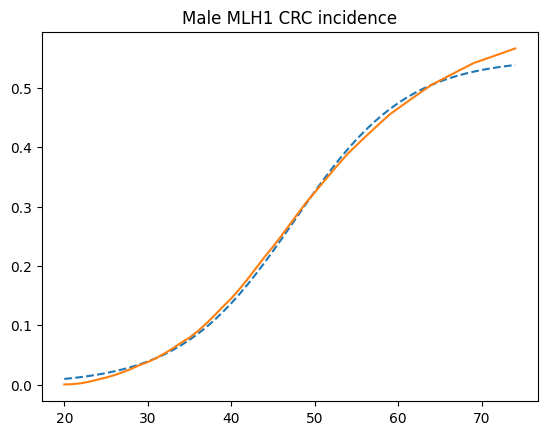

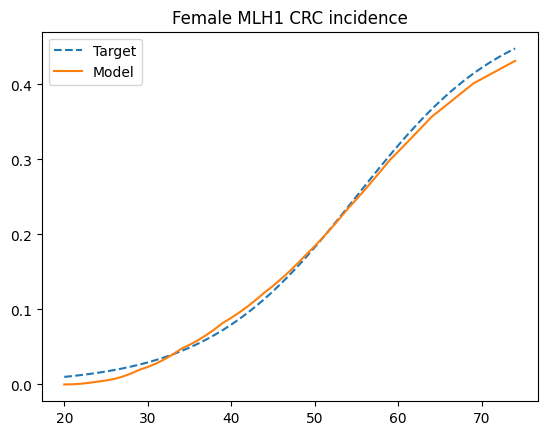

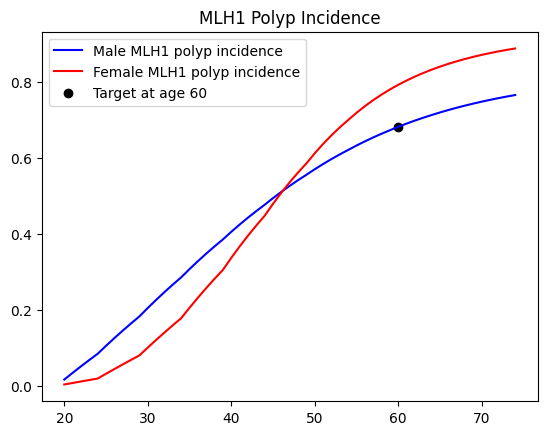

In [16]:
for gene in c.GENES:   
    plot_crc_incidence(result_log, gene)
    
for gene in c.GENES:
    plot_polyp_incidence(result_log, gene)

In [17]:
for gene in c.GENES:
    print(gene, get_total_incidence(result_log, gene))

MLH1 [ 56.665563175  43.139971854]


In [18]:

inc_unadj = result_log[2]
stage_idx = [7, 8, 9, 10]  # stage_1..stage_4
stage_totals = inc_unadj[:, 0, stage_idx, :].sum(axis=(2)).sum(axis=0)
total_crc = stage_totals.sum()
print(stage_totals/total_crc*100)

[ 40.400766050  35.663968198  18.250398744  5.684867008]


In [19]:
np.save("../tmats/MLH1_20250914_2001.npy", result)

In [20]:
tm = result[:,1,:,:,:].mean(axis=0) # average over sex for gene MLH1
in_1, in_2, in_3, in_4 = [1/(1-tm[:, x, x].mean(axis=0)) for x in [4,5,6,7]]
m1 = in_1
m2 = in_1 + in_2
m3 = (in_1 * in_2 * tm[:, 4, 5]) + in_3
m4 = (in_1 * in_2 * tm[:, 4, 5] * in_3 * tm[:, 5, 6]) + in_4

sj_time = np.array([m1,m2,m3,m4])
sj_time_mean = np.mean(sj_time, axis=0)


IndexError: index 1 is out of bounds for axis 1 with size 1

In [21]:
# Get mean transition matrix over sex
tm = result[:, 0, :, :, :].mean(axis=0)  # (n_age_layers, n_states, n_states)

# Expected duration in each stage
dur = [1 / (1 - tm[:, x, x]) for x in [4, 5, 6, 7]]  # stays in 4,5,6,7

# Optional: weighted by transition probability
m1 = dur[0]
m2 = dur[1]
m3 = dur[2] * tm[:, 4, 5]
m4 = dur[3] * tm[:, 4, 5] * tm[:, 5, 6]

# Total sojourn time per age layer
sj_time = m1 + m2 + m3 + m4

# Average across age layers
sj_time_mean = sj_time.mean()


In [22]:
sj_time_mean 

np.float64(38.192728471792776)

In [27]:
dur = sum(1 / (1 - tm[:, x, x].mean()) for x in [1, 2])  # stays in lr_polyp, hr_polyp
print(dur)

15.971359298518758
